In [1]:
#importing libraries
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input,Dense
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras import regularizers
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve, accuracy_score
from sklearn.metrics import precision_recall_fscore_support, f1_score
from pandas.api.types import is_numeric_dtype
import urllib

In [55]:
#loading the dataset
url = "http://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data"
raw_data = urllib.request.urlopen(url)
data = pd.read_csv(url, delimiter = ' ', header = None)

data.columns = ['HasChecking', 'DurationInMonths', 'CreditHistory', 'CreditPurpose', 'CreditAmount',
'SavingsAccount', 'EmployedSince', 'InstallmentRatePercentIncome', 'StatusGender',
'OtherDebtorsGuarantors', 'ResidenceSince', 'Property', 'Age', 'OtherInstallmentPlans', 'Housing',
'NumberExistingCredits', 'Job', 'FamilyLiablities', 'HasPhone', 'ForeignWorker', 'CreditRisk']

In [56]:
data.head()

,HasChecking,DurationInMonths,CreditHistory,CreditPurpose,CreditAmount,SavingsAccount,EmployedSince,InstallmentRatePercentIncome,StatusGender,OtherDebtorsGuarantors,...,Property,Age,OtherInstallmentPlans,Housing,NumberExistingCredits,Job,FamilyLiablities,HasPhone,ForeignWorker,CreditRisk
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,2


In [57]:
#finding out numeric data
numerical_features = [f for f in list(data) if is_numeric_dtype(data[f])]
numerical_features

['DurationInMonths',
 'CreditAmount',
 'InstallmentRatePercentIncome',
 'ResidenceSince',
 'Age',
 'NumberExistingCredits',
 'FamilyLiablities',
 'CreditRisk']

In [58]:
non_numerical_features = [f for f in list(data) if not is_numeric_dtype(data[f])]
non_numerical_features

['HasChecking',
 'CreditHistory',
 'CreditPurpose',
 'SavingsAccount',
 'EmployedSince',
 'StatusGender',
 'OtherDebtorsGuarantors',
 'Property',
 'OtherInstallmentPlans',
 'Housing',
 'Job',
 'HasPhone',
 'ForeignWorker']

In [59]:
#making dummy variables out of non_numerical_features
#pd.get_dummies does the one-hot encoding for categorical data automatically
data_ready = pd.get_dummies(data, columns = non_numerical_features, drop_first = False, dummy_na = False)
print(data_ready.shape)
data_ready.head()

(1000, 62)


,DurationInMonths,CreditAmount,InstallmentRatePercentIncome,ResidenceSince,Age,NumberExistingCredits,FamilyLiablities,CreditRisk,HasChecking_A11,HasChecking_A12,...,Housing_A152,Housing_A153,Job_A171,Job_A172,Job_A173,Job_A174,HasPhone_A191,HasPhone_A192,ForeignWorker_A201,ForeignWorker_A202
0,6,1169,4,4,67,2,1,1,1,0,...,1,0,0,0,1,0,0,1,1,0
1,48,5951,2,2,22,1,1,2,0,1,...,1,0,0,0,1,0,1,0,1,0
2,12,2096,2,3,49,1,2,1,0,0,...,1,0,0,1,0,0,1,0,1,0
3,42,7882,2,4,45,1,2,1,1,0,...,0,1,0,0,1,0,1,0,1,0
4,24,4870,3,4,53,2,2,2,1,0,...,0,1,0,0,1,0,1,0,1,0


In [60]:
#acc to dataset description, we know that (1 is good credit and 2 is bad credit)
data_ready[['CreditRisk','HasChecking_A11','HasChecking_A12','HasChecking_A13','HasChecking_A14']].groupby('CreditRisk').sum()

,HasChecking_A11,HasChecking_A12,HasChecking_A13,HasChecking_A14
CreditRisk,,,,
1,139.0,164.0,49.0,348.0
2,135.0,105.0,14.0,46.0


In [61]:
#Now instead of (1 is good credit and 2 is bad credit) we have (0 is good credit and 1 is bad credit)
data_ready['CreditRisk'].replace([1,2], [0,1], inplace = True)
data_ready['CreditRisk'].value_counts()

0    700
1    300
Name: CreditRisk, dtype: int64

In [62]:
data_ready.to_csv("german-credit-scores-ready.csv", index = None)

In [63]:
print(data_ready.shape)

(1000, 62)


In [64]:
features = [f for f in list(data_ready) if f not in ['CreditRisk']]
len(features)

61

In [65]:
X_train, X_test, Y_train, Y_test = train_test_split(data_ready[features], data_ready['CreditRisk'], test_size=0.3, 
                                                    random_state=1)
print('Data split - Train:', len(X_train), 'Test:', len(X_test))

Data split - Train: 700 Test: 300


In [66]:
# check for nulls
X_train.isnull().values.sum()

0

In [67]:
#creating a set of negative outcomes. Negative outcomes means good credit risk. this is what we train our
#models on. For sorting good credit risk customers only, carry out the following operations:
X_train_0 = X_train.copy()
X_train_0['CreditRisk'] = Y_train #reattaching credit risk column of the train split
#print(X_train_0['CreditRisk']==0)
X_train_0 = X_train_0[X_train_0['CreditRisk']==0] #keeping only entries of customers with good credit risk
X_train_0 = X_train_0.drop('CreditRisk', axis = 1)

X_test_0 = X_test.copy()
X_test_0['CreditRisk'] = Y_test
X_test_0 = X_test_0[X_test_0['CreditRisk']==0]
X_test_0 = X_test_0.drop('CreditRisk', axis = 1)

In [75]:
epochs = 288
batch_size = 128
input_dim = X_train_0.shape[1]
encoding_dim = 24
hidden_dim = int(encoding_dim/2)
hidden_dim_2 = int(hidden_dim/2)
#change learning rate if the learning rate does not converge
learning_rate = 1e-3

#autoencoder layers
input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation = 'relu', activity_regularizer = regularizers.l1(learning_rate))(input_layer)
encoder = Dense(hidden_dim, activation= 'relu')(encoder)
encoder = Dense(hidden_dim_2, activation = 'relu')(encoder)
decoder = Dense(hidden_dim_2, activation = 'relu')(encoder)
decoder = Dense(hidden_dim, activation ='relu')(decoder)
decoder = Dense(encoding_dim, activation = 'relu')(decoder)
decoder = Dense(input_dim, activation = 'linear')(decoder)
autoencoder = Model(inputs = input_layer, outputs = decoder)
autoencoder.summary()

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 61)]              0         
_________________________________________________________________
dense_28 (Dense)             (None, 24)                1488      
_________________________________________________________________
dense_29 (Dense)             (None, 12)                300       
_________________________________________________________________
dense_30 (Dense)             (None, 6)                 78        
_________________________________________________________________
dense_31 (Dense)             (None, 6)                 42        
_________________________________________________________________
dense_32 (Dense)             (None, 12)                84        
_________________________________________________________________
dense_33 (Dense)             (None, 24)               

In [76]:
autoencoder.compile(metrics=['accuracy'], loss='mean_squared_error', optimizer='adam')

cp = ModelCheckpoint(filepath="autoencoder_classifier.h5", save_best_only=True, verbose=0)

tb = TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=True)

history = autoencoder.fit(X_train_0, X_train_0, epochs=epochs, batch_size=batch_size, shuffle=True, 
                          validation_data = (X_test_0, X_test_0),verbose=1, callbacks=[cp, tb]).history

Epoch 1/288
4/4 [==============================] - 0s 59ms/step - loss: 238600.8438 - accuracy: 0.0000e+00 - val_loss: 250855.7812 - val_accuracy: 0.0000e+00
Epoch 2/288
4/4 [==============================] - 0s 14ms/step - loss: 237566.5156 - accuracy: 0.0000e+00 - val_loss: 249965.9688 - val_accuracy: 0.0000e+00
Epoch 3/288
4/4 [==============================] - 0s 14ms/step - loss: 236804.1250 - accuracy: 0.0000e+00 - val_loss: 249470.4375 - val_accuracy: 0.0000e+00
Epoch 4/288
4/4 [==============================] - 0s 7ms/step - loss: 236637.9844 - accuracy: 0.0000e+00 - val_loss: 249615.4375 - val_accuracy: 0.0000e+00
Epoch 5/288
4/4 [==============================] - 0s 9ms/step - loss: 236664.9062 - accuracy: 0.0000e+00 - val_loss: 249508.1094 - val_accuracy: 0.0000e+00
Epoch 6/288
4/4 [==============================] - 0s 16ms/step - loss: 236551.2656 - accuracy: 0.0000e+00 - val_loss: 249408.8594 - val_accuracy: 0.0000e+00
Epoch 7/288
4/4 [==============================] - 0s 

4/4 [==============================] - 0s 13ms/step - loss: 45.0969 - accuracy: 1.0000 - val_loss: 39.9063 - val_accuracy: 1.0000
Epoch 54/288
4/4 [==============================] - 0s 14ms/step - loss: 39.3607 - accuracy: 1.0000 - val_loss: 34.1700 - val_accuracy: 1.0000
Epoch 55/288
4/4 [==============================] - 0s 13ms/step - loss: 35.0122 - accuracy: 1.0000 - val_loss: 32.0910 - val_accuracy: 1.0000
Epoch 56/288
4/4 [==============================] - 0s 13ms/step - loss: 33.9667 - accuracy: 1.0000 - val_loss: 31.4552 - val_accuracy: 1.0000
Epoch 57/288
4/4 [==============================] - 0s 7ms/step - loss: 33.2047 - accuracy: 1.0000 - val_loss: 31.6662 - val_accuracy: 1.0000
Epoch 58/288
4/4 [==============================] - 0s 8ms/step - loss: 33.2780 - accuracy: 1.0000 - val_loss: 31.4872 - val_accuracy: 1.0000
Epoch 59/288
4/4 [==============================] - 0s 14ms/step - loss: 33.0199 - accuracy: 1.0000 - val_loss: 31.3716 - val_accuracy: 1.0000
Epoch 60/288
4

4/4 [==============================] - 0s 13ms/step - loss: 26.2013 - accuracy: 1.0000 - val_loss: 24.9479 - val_accuracy: 1.0000
Epoch 111/288
4/4 [==============================] - 0s 13ms/step - loss: 26.0953 - accuracy: 1.0000 - val_loss: 24.6469 - val_accuracy: 1.0000
Epoch 112/288
4/4 [==============================] - 0s 14ms/step - loss: 25.9251 - accuracy: 1.0000 - val_loss: 24.5083 - val_accuracy: 1.0000
Epoch 113/288
4/4 [==============================] - 0s 13ms/step - loss: 25.8530 - accuracy: 1.0000 - val_loss: 24.4007 - val_accuracy: 1.0000
Epoch 114/288
4/4 [==============================] - 0s 14ms/step - loss: 25.6626 - accuracy: 1.0000 - val_loss: 24.3405 - val_accuracy: 1.0000
Epoch 115/288
4/4 [==============================] - 0s 15ms/step - loss: 25.6502 - accuracy: 1.0000 - val_loss: 24.2741 - val_accuracy: 1.0000
Epoch 116/288
4/4 [==============================] - 0s 13ms/step - loss: 25.6208 - accuracy: 1.0000 - val_loss: 24.1241 - val_accuracy: 1.0000
Epoch 

4/4 [==============================] - 0s 14ms/step - loss: 20.3535 - accuracy: 1.0000 - val_loss: 19.4504 - val_accuracy: 1.0000
Epoch 168/288
4/4 [==============================] - 0s 8ms/step - loss: 20.3475 - accuracy: 1.0000 - val_loss: 19.5764 - val_accuracy: 1.0000
Epoch 169/288
4/4 [==============================] - 0s 7ms/step - loss: 20.4762 - accuracy: 1.0000 - val_loss: 19.5687 - val_accuracy: 1.0000
Epoch 170/288
4/4 [==============================] - 0s 6ms/step - loss: 20.5911 - accuracy: 1.0000 - val_loss: 19.8754 - val_accuracy: 1.0000
Epoch 171/288
4/4 [==============================] - 0s 7ms/step - loss: 20.8773 - accuracy: 1.0000 - val_loss: 19.9054 - val_accuracy: 1.0000
Epoch 172/288
4/4 [==============================] - 0s 6ms/step - loss: 20.7211 - accuracy: 1.0000 - val_loss: 19.6780 - val_accuracy: 1.0000
Epoch 173/288
4/4 [==============================] - 0s 7ms/step - loss: 20.7195 - accuracy: 1.0000 - val_loss: 19.5493 - val_accuracy: 1.0000
Epoch 174/28

4/4 [==============================] - 0s 6ms/step - loss: 19.7564 - accuracy: 1.0000 - val_loss: 18.8907 - val_accuracy: 1.0000
Epoch 225/288
4/4 [==============================] - 0s 7ms/step - loss: 19.8321 - accuracy: 1.0000 - val_loss: 19.1556 - val_accuracy: 1.0000
Epoch 226/288
4/4 [==============================] - 0s 6ms/step - loss: 20.1368 - accuracy: 1.0000 - val_loss: 18.8359 - val_accuracy: 1.0000
Epoch 227/288
4/4 [==============================] - 0s 7ms/step - loss: 20.0414 - accuracy: 1.0000 - val_loss: 18.9400 - val_accuracy: 1.0000
Epoch 228/288
4/4 [==============================] - 0s 8ms/step - loss: 19.8731 - accuracy: 1.0000 - val_loss: 19.5139 - val_accuracy: 1.0000
Epoch 229/288
4/4 [==============================] - 0s 7ms/step - loss: 20.1818 - accuracy: 1.0000 - val_loss: 18.9475 - val_accuracy: 1.0000
Epoch 230/288
4/4 [==============================] - 0s 6ms/step - loss: 19.9994 - accuracy: 1.0000 - val_loss: 19.0077 - val_accuracy: 1.0000
Epoch 231/288

4/4 [==============================] - 0s 7ms/step - loss: 19.4491 - accuracy: 1.0000 - val_loss: 18.5718 - val_accuracy: 1.0000
Epoch 282/288
4/4 [==============================] - 0s 7ms/step - loss: 19.4590 - accuracy: 1.0000 - val_loss: 18.5714 - val_accuracy: 1.0000
Epoch 283/288
4/4 [==============================] - 0s 7ms/step - loss: 19.5239 - accuracy: 1.0000 - val_loss: 18.7629 - val_accuracy: 1.0000
Epoch 284/288
4/4 [==============================] - 0s 6ms/step - loss: 19.6234 - accuracy: 1.0000 - val_loss: 18.9640 - val_accuracy: 1.0000
Epoch 285/288
4/4 [==============================] - 0s 7ms/step - loss: 19.6564 - accuracy: 1.0000 - val_loss: 18.6455 - val_accuracy: 1.0000
Epoch 286/288
4/4 [==============================] - 0s 7ms/step - loss: 19.5757 - accuracy: 1.0000 - val_loss: 18.7275 - val_accuracy: 1.0000
Epoch 287/288
4/4 [==============================] - 0s 8ms/step - loss: 19.5883 - accuracy: 1.0000 - val_loss: 18.5238 - val_accuracy: 1.0000
Epoch 288/288

In [77]:
autoencoder


In [78]:
test_x_predictions = autoencoder.predict(X_test)
print(test_x_predictions.shape)
mse = np.mean(np.power(X_test - test_x_predictions, 2), axis = 1)
mse

(300, 61)


507     14.241956
818    138.527396
452      3.494809
368      9.656537
242     11.606045
          ...    
459      1.365885
415      2.304802
61      25.499211
347      1.118233
349      9.651439
Length: 300, dtype: float64

In [79]:
Y_test.value_counts()

0    214
1     86
Name: CreditRisk, dtype: int64

In [80]:
fpr, tpr, thresholds = roc_curve(Y_test, mse)
print("thresholds", np.mean(thresholds))
auc(fpr, tpr)

thresholds 18.4943173545885


0.5833514453379698

In [81]:
threshold_fixed = 18.4943173545885
accuracy_score(Y_test, [1 if s > threshold_fixed else 0 for s in mse])

0.6466666666666666

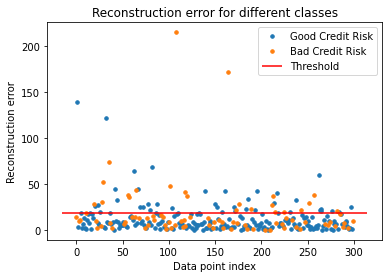

In [82]:
error_df_test = pd.DataFrame({'Reconstruction_error': mse,
'True_class': Y_test})
error_df_test = error_df_test.reset_index()
groups = error_df_test.groupby('True_class')
fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='', label= "Bad Credit Risk" if name == 1 else "Good Credit Risk")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

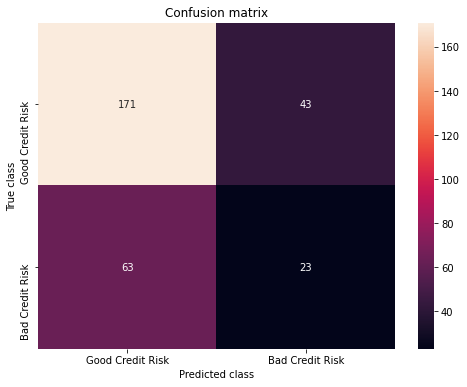

In [83]:
pred_y = [1 if e > threshold_fixed else 0 for e in error_df_test['Reconstruction_error'].values]
conf_matrix = confusion_matrix(error_df_test['True_class'], pred_y)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix,
xticklabels=["Good Credit Risk","Bad Credit Risk"],
yticklabels=["Good Credit Risk","Bad Credit Risk"],
annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

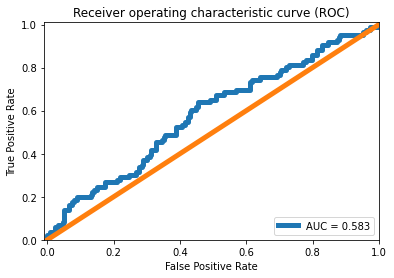

In [84]:
false_pos_rate, true_pos_rate, thresholds = roc_curve(error_df_test['True_class'],
error_df_test['Reconstruction_error'])
roc_auc = auc(false_pos_rate, true_pos_rate,)
plt.plot(false_pos_rate, true_pos_rate, linewidth=5, label='AUC = %0.3f'% roc_auc)
plt.plot([0,1],[0,1], linewidth=5)
plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right')
plt.title('Receiver operating characteristic curve (ROC)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [85]:
X_test['Error'] = mse
X_test['CreditRisk'] = Y_test
X_test = X_test.sort_values('Error', ascending=False)
X_test.head()

,DurationInMonths,CreditAmount,InstallmentRatePercentIncome,ResidenceSince,Age,NumberExistingCredits,FamilyLiablities,HasChecking_A11,HasChecking_A12,HasChecking_A13,...,Job_A171,Job_A172,Job_A173,Job_A174,HasPhone_A191,HasPhone_A192,ForeignWorker_A201,ForeignWorker_A202,Error,CreditRisk
236,6,14555,1,2,23,1,1,0,1,0,...,1,0,0,0,0,1,1,0,214.708125,1
887,48,15672,2,2,23,1,1,0,1,0,...,0,0,1,0,0,1,1,0,172.008493,1
818,36,15857,2,3,43,1,1,1,0,0,...,0,0,0,1,1,0,1,0,138.527396,0
744,39,14179,4,4,30,2,1,1,0,0,...,0,0,0,1,0,1,1,0,121.702278,0
274,30,11998,1,1,34,1,1,1,0,0,...,0,1,0,0,0,1,1,0,73.659130,1


In [86]:
normal_values = X_test[X_test['CreditRisk']==0].mean()
normal_values

DurationInMonths                  19.191589
CreditAmount                    3053.785047
InstallmentRatePercentIncome       3.018692
ResidenceSince                     2.808411
Age                               35.542056
                                   ...     
HasPhone_A192                      0.425234
ForeignWorker_A201                 0.943925
ForeignWorker_A202                 0.056075
Error                             12.257448
CreditRisk                         0.000000
Length: 63, dtype: float64

In [87]:
diff_values = normal_values - X_test.head(10)
diff_values = diff_values.T
diff_values

,236,887,818,744,274,756,395,187,374,13
DurationInMonths,13.191589,-28.808411,-16.808411,-19.808411,-10.808411,13.191589,-19.808411,3.191589,-40.808411,-4.808411
CreditAmount,-11501.214953,-12618.214953,-12803.214953,-11125.214953,-8944.214953,1754.785047,-8706.214953,1878.785047,-11728.214953,1854.785047
InstallmentRatePercentIncome,2.018692,1.018692,1.018692,-0.981308,2.018692,2.018692,1.018692,1.018692,0.018692,-0.981308
ResidenceSince,0.808411,0.808411,-0.191589,-1.191589,1.808411,1.808411,-0.191589,-0.191589,-1.191589,-1.191589
Age,12.542056,12.542056,-7.457944,5.542056,1.542056,-38.457944,3.542056,-32.457944,-24.457944,-24.457944
...,...,...,...,...,...,...,...,...,...,...
HasPhone_A192,-0.574766,-0.574766,0.425234,-0.574766,-0.574766,0.425234,-0.574766,-0.574766,-0.574766,0.425234
ForeignWorker_A201,-0.056075,-0.056075,-0.056075,-0.056075,-0.056075,0.943925,-0.056075,-0.056075,-0.056075,-0.056075
ForeignWorker_A202,0.056075,0.056075,0.056075,0.056075,0.056075,-0.943925,0.056075,0.056075,0.056075,0.056075
Error,-202.450676,-159.751045,-126.269947,-109.444829,-61.401682,-56.047766,-51.499706,-47.276241,-40.061329,-35.789243


In [88]:
# pick an index header and analyze
customer = 13
to_analyze = pd.DataFrame(diff_values[customer])
to_analyze = to_analyze.sort_values(customer, ascending=True)
print(to_analyze.head(1))
print(to_analyze.tail(1))

              13
Error -35.789243
                       13
CreditAmount  1854.785047


In [89]:
customer = 274
to_analyze = pd.DataFrame(diff_values[customer])
to_analyze = to_analyze.sort_values(customer, ascending=True)
print(to_analyze.head(1))
print(to_analyze.tail(1))

                      274
CreditAmount -8944.214953
                                   274
InstallmentRatePercentIncome  2.018692
